# Imports

In [1]:
from utils import *

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_photo = path_scan + 'ProfiloFoto/'       # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5 # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

### Experimental setting ###
angle_incidence = 10.5 # angle between the incident beam and the plane of the painting
channel_distance = 50 # distance in microns between two adjacent channels of the detector

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

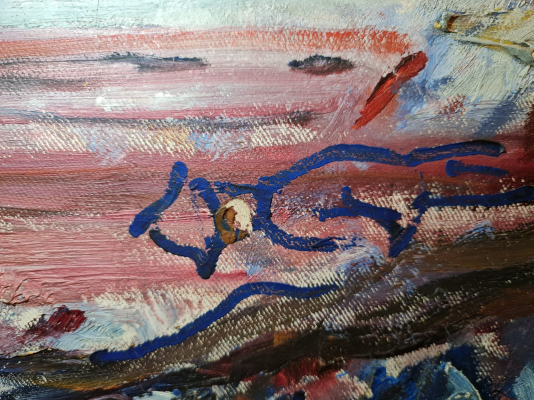

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.reduce(3))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

y_x_ratio = data.shape[0] / data.shape[1]
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 367


# Burnt pixels

### Show them
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

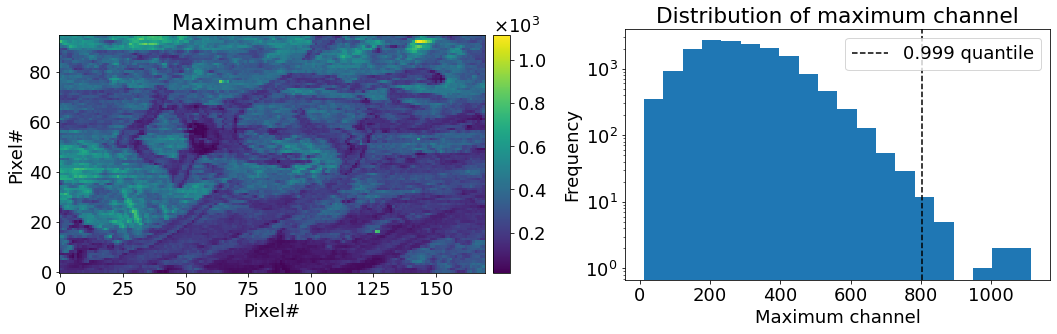

17 pixels out of 16150 are selected as burnt.


In [7]:
rcParams['font.size'] = 18

qtl = 0.999
#qtl = 1

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 'doane') # 'sqrt'
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct them
Substitute burnt pixel with the average of the non burnt ones.

In [8]:
data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

### Integral, average and maximum

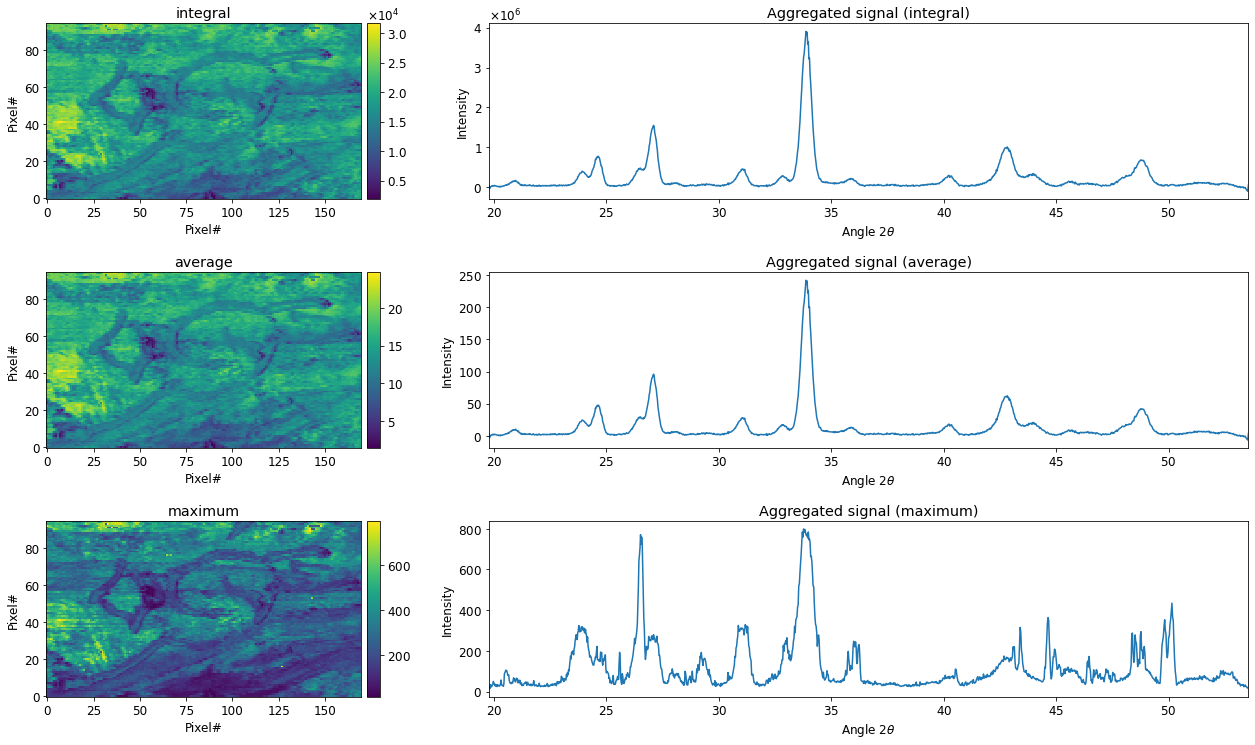

In [9]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (18, 3 * 6 * y_x_ratio), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):
    
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

### Rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

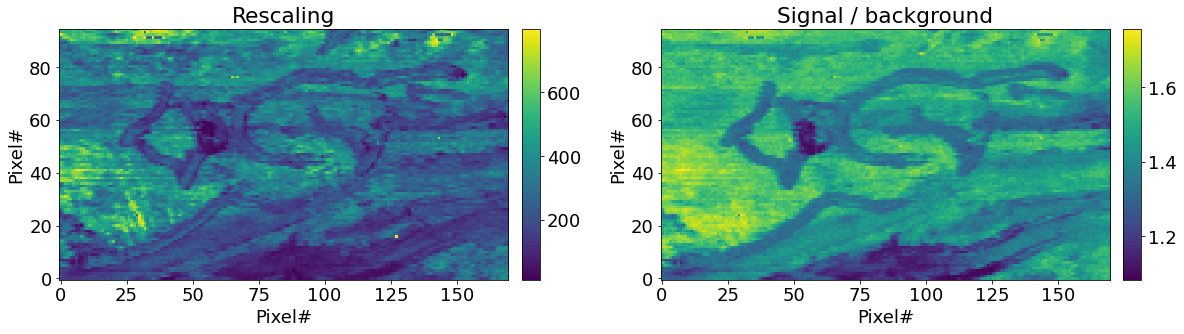

In [10]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (16, 8 * y_x_ratio))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [11]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [12]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

17 pixels out of 16150 were corrected on average in each XRF map.


### Correct wrong scale that includes negative values

In [13]:
data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

# Explore XRF data

### All XRF maps

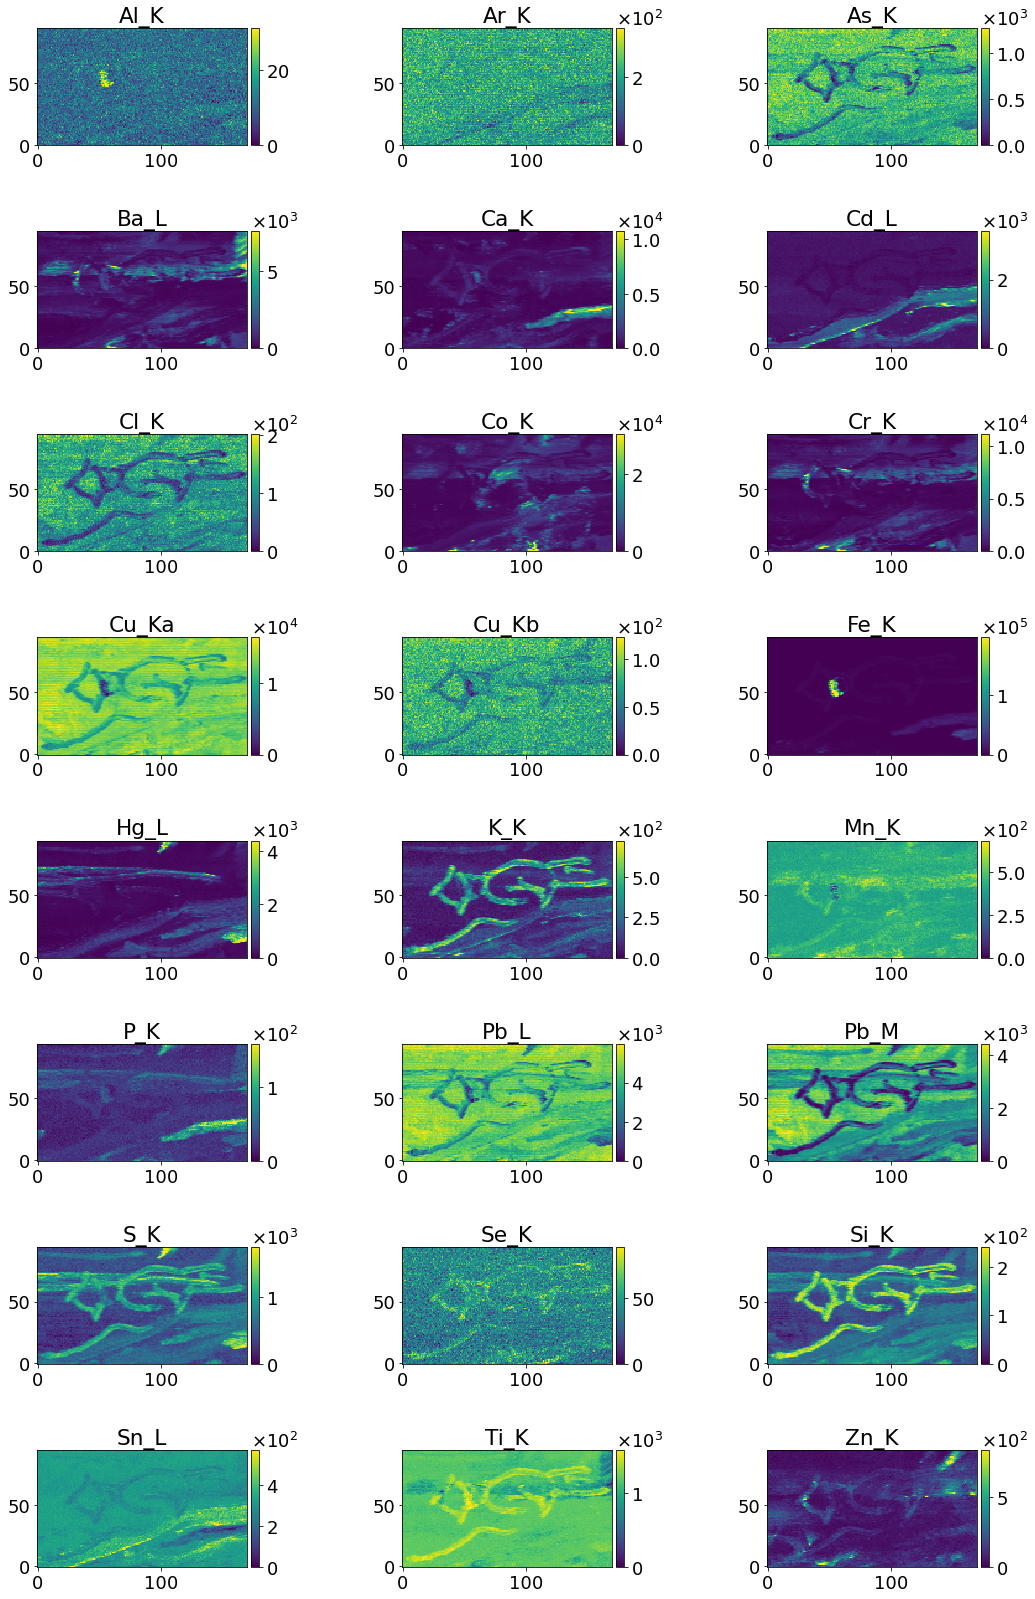

In [14]:
#%matplotlib qt
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 5 * n_of_rows * y_x_ratio))
fig.tight_layout(h_pad = 3, w_pad = 3)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

### XRF maps of selected element

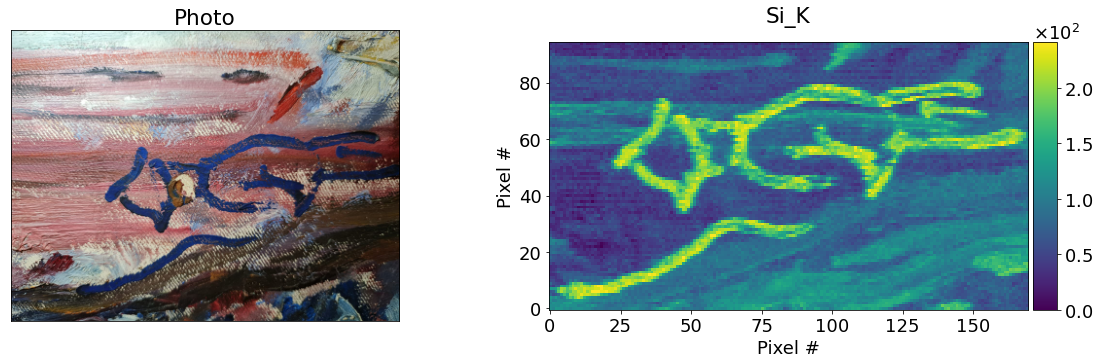

In [15]:
%matplotlib inline
#%matplotlib qt
rcParams['font.size'] = 18

element_chosen = 'Si'

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
        fig.tight_layout(w_pad = 3)

        ax = axs[0]
        filename_photo = glob(path_photo + '*.jpg')[0]
        im = Image.open(filename_photo).transpose(1)
        ax.imshow(im.reduce(4))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title('Photo')
        
        ax = axs[1]
        im = ax.imshow(data_xrf.labels[..., i], interpolation = 'none')
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.01, 0, 0.05, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_xlabel('Pixel #')
        ax.set_ylabel('Pixel #')
        ax.set_title(label, y = 1.05)

show()

### RGB map from 3 XRF maps

Pb:	Pb_L
Hg:	Hg_L
Si:	Si_K


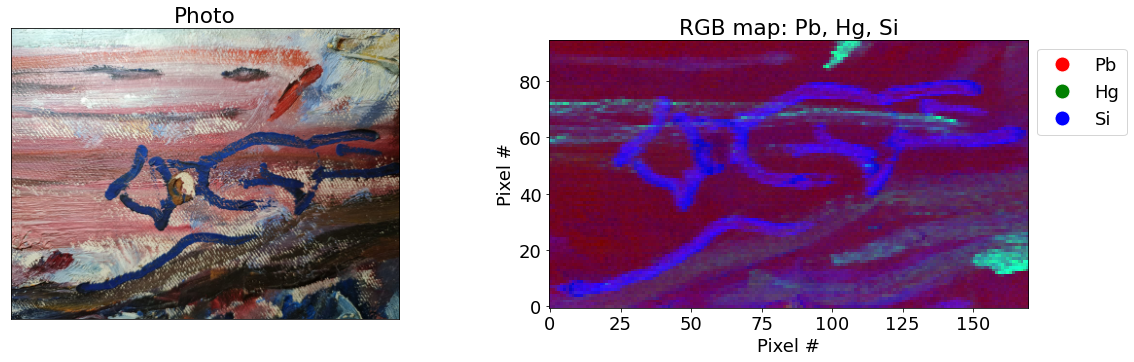

In [16]:
rcParams['font.size'] = 18
elements_chosen = ['Pb', 'Hg', 'Si']
factors_intensity = [0.5, 1, 1]

check_find = [False] * 3
image_rgb = empty(list(data_xrf.labels.shape[:2]) + [3])
for i, elem in enumerate(elements_chosen):
    j = find_element(elem, data_xrf.metadata['labels'])
    if j is None:
        print(elem + ' not found.')
    else:
        print(elem + ':\t' + data_xrf.metadata['labels'][j])
        check_find[i] = True
        image_rgb[..., i] = data_xrf.labels[..., j]

if all(check_find):
    image_rgb -= image_rgb.min(axis = (0, 1), keepdims = True)
    image_rgb /= image_rgb.max(axis = (0, 1), keepdims = True)
    image_rgb *= array(factors_intensity)[newaxis, newaxis, :]
    #image_rgb /= image_rgb.max()
    image_rgb = clip(image_rgb, 0, 1)

    fig, axs = subplots(1, 2, figsize = (16, 9 * y_x_ratio))
    fig.tight_layout(w_pad = 3)

    ax = axs[0]
    filename_photo = glob(path_photo + '*.jpg')[0]
    im = Image.open(filename_photo).transpose(1)
    ax.imshow(im.reduce(4))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title('Photo')
        
    ax = axs[1]
    im = ax.imshow(image_rgb, interpolation = 'none')
    legend_elements = [
        Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = c, markersize = 15, label = elements_chosen[i])
            for i, c in enumerate(['r', 'g', 'b'])
    ]
    ax.legend(handles = legend_elements, bbox_to_anchor = (1, 1), loc = 'upper left')
    ax.set_xlabel('Pixel #')
    ax.set_ylabel('Pixel #')
    ax.set_title('RGB map: ' + ', '.join(elements_chosen))

    show()

extent = ax.get_tightbbox(fig.canvas.renderer).expanded(1.05, 1.05).transformed(fig.dpi_scale_trans.inverted())
fig.savefig(path_figures + 'RGB_' + '_'.join(elements_chosen) + '.png', bbox_inches = extent)

# List of phases

### Search phases with given elements and select the best sample for each phase

- `elements_chosen`: Elements that need to be in the selected phases.
- `threshold_XRF_intensity`: The routine selects pixels where the first of `elements_chosen` has an XRF intensity above this threshold value.
- `elements_excluded`: Elements that must not be in the selected phases.

In [27]:
elements_chosen = ['Fe']
threshold_XRF_intensity = 0.7
elements_excluded = ['Mn', 'Ni']

i = find_element(elements_chosen[0], data_xrf.metadata['labels'])
print('Element chosen for the map of XRF intensity: ' + data_xrf.metadata['labels'][i])
print(f'Threshold: {threshold_XRF_intensity}')

indices_XRF_sel = zeros(data.shape[:2], bool)
map_XRF_intensity = data_xrf.labels[..., i] / data_xrf.labels[..., i].max()
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if map_XRF_intensity[y, x] >= threshold_XRF_intensity:
            indices_XRF_sel[y, x] = True
print(f'Selected pixels: {indices_XRF_sel.sum()}')

list_name = []
list_formula = []
list_number = []
list_index_best_average = []
list_value_best_average = []
list_index_best_max = []
list_coord_best_max = []
list_value_best_max = []
for k, v in sorted(database.items()):
    p = v[0]
    if '_chemical_formula_sum' in p:
        if (all(e in p['_chemical_formula_sum'] for e in elements_chosen)
            and all(e not in p['_chemical_formula_sum'] for e in elements_excluded)):
            list_name.append(k)
            list_formula.append(p['_chemical_formula_sum'])
            list_number.append(len(v))
            
            print(f'Calculations for {k} ({len(v)})... ', end = '')
            phases_samples = [p for p in v]
            gm = GammaMap_Partial().from_data(data, phases_samples, indices_XRF_sel, sigma = sigma, min_theta = min_theta,
                                              max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
            gm = gm.fit_cycle(gamma = True, steps = 10, verbose = False)
            overlap = gm.overlap3_area_ratio(verbose = False)
            overlap_average = overlap.mean(axis = 0)
            overlap_max = overlap.max(axis = 0)
            
            j = nanargmax(overlap_average)
            list_index_best_average.append(j)
            list_value_best_average.append(overlap_average[j])
            j = nanargmax(overlap_max)
            list_index_best_max.append(j)
            list_coord_best_max.append(gm.get_x_y(nanargmax(overlap[:, j])))
            list_value_best_max.append(overlap_max[j])
            
            print('Done.')

phases_from_elements = DataFrame({
    'Name in database': list_name,
    'Chemical formula': list_formula,
    'N. of samples': list_number,
    'Sample best avg': list_index_best_average,
    'Value best avg': list_value_best_average,
    'Sample best max': list_index_best_max,
    '(x, y) best max': list_coord_best_max,
    'Value best max': list_value_best_max
})

phases_from_elements.style.format({
    'Value best avg': '{:.3f}',
    'Value best max': '{:.3f}'
})

Element chosen for the map of XRF intensity: Fe_K
Threshold: 0.7
Selected pixels: 55
Calculations for Akaganeite (2)... Done.
Calculations for Fe2 O3 (10)... Done.
Calculations for Goethite (22)... Done.
Calculations for Hematite (11)... Done.
Calculations for Jarosite (16)... Done.
Calculations for Lepidocrocite (2)... Done.
Calculations for Magnetite (1)... Done.
Calculations for Pyrite (9)... Done.
Calculations for Siderite (2)... Done.
Calculations for Wuestite (11)... Done.
Calculations for hematite (2)... Done.


### Check the fit of every phase in the point of maximum overlap and save figures

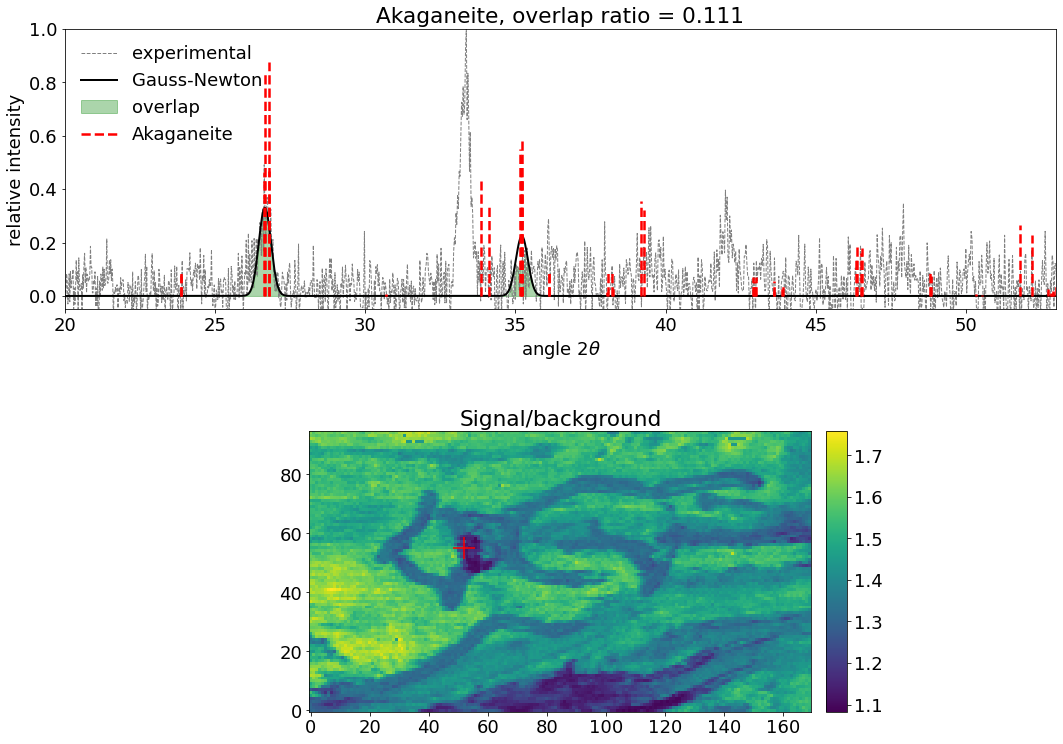

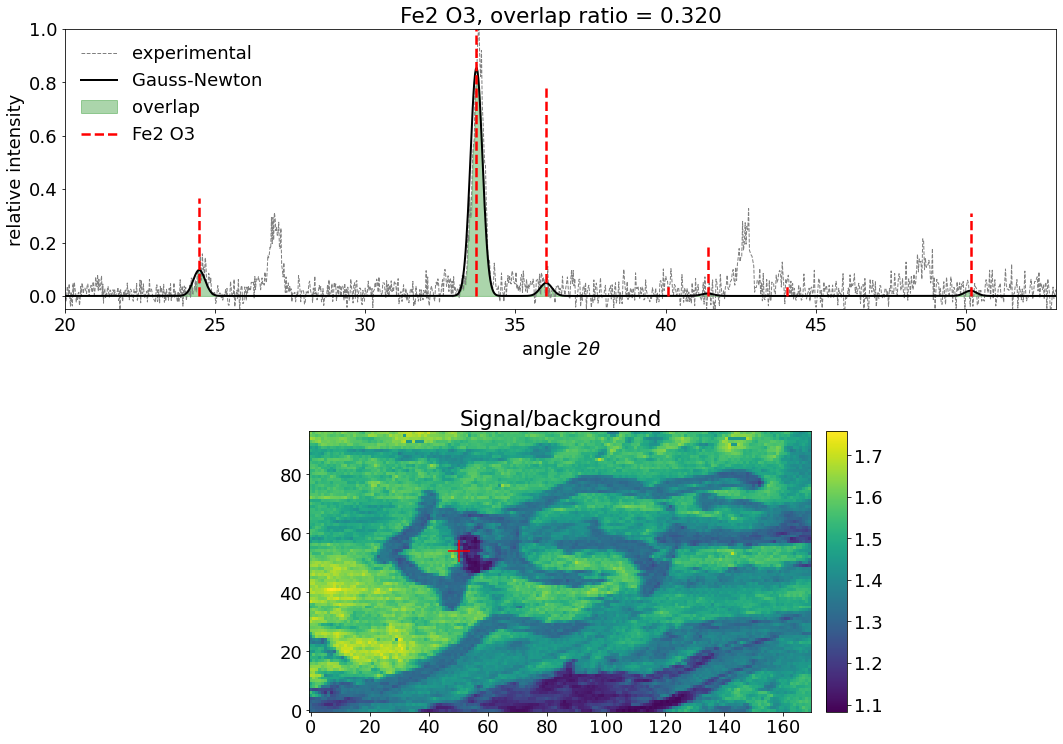

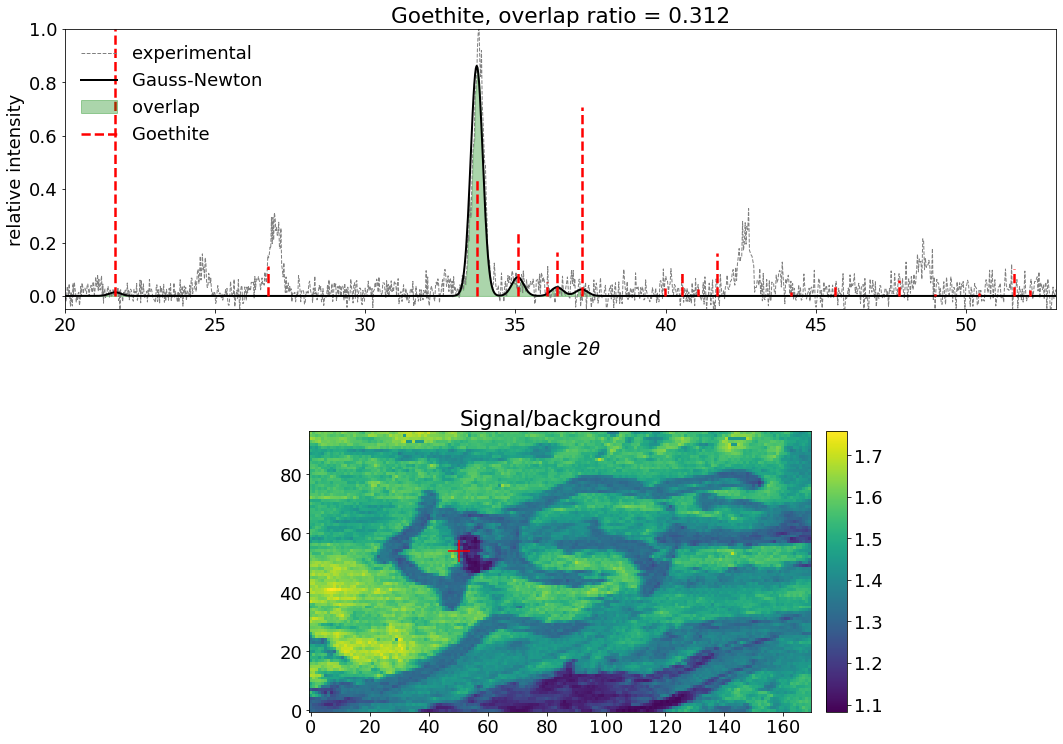

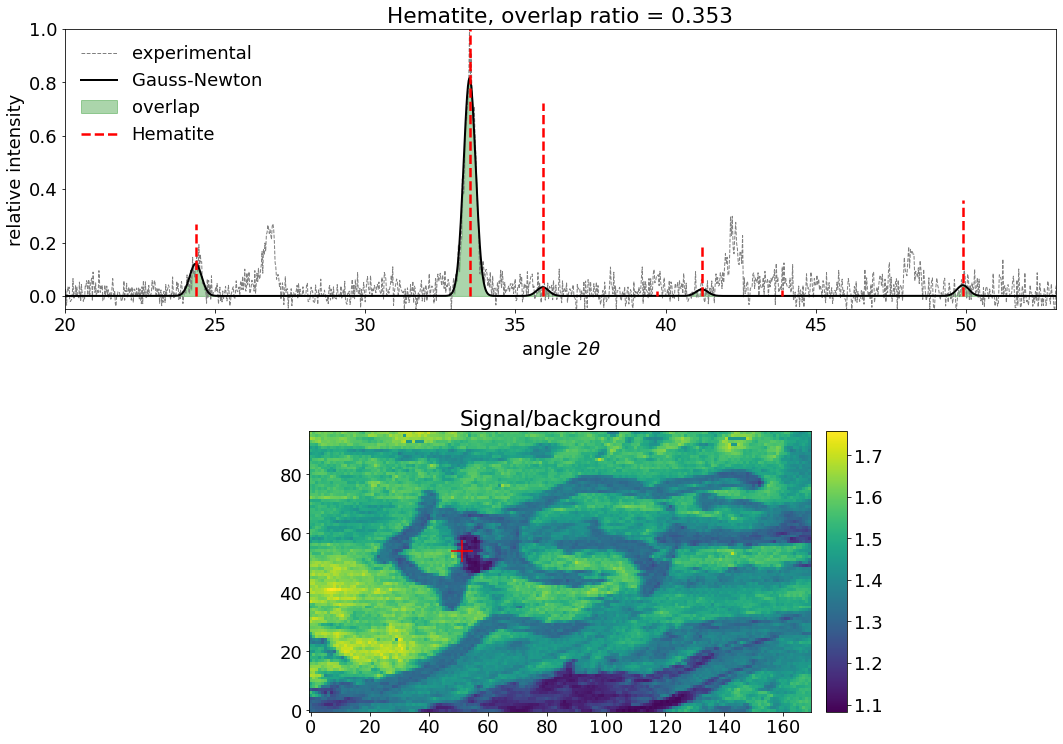

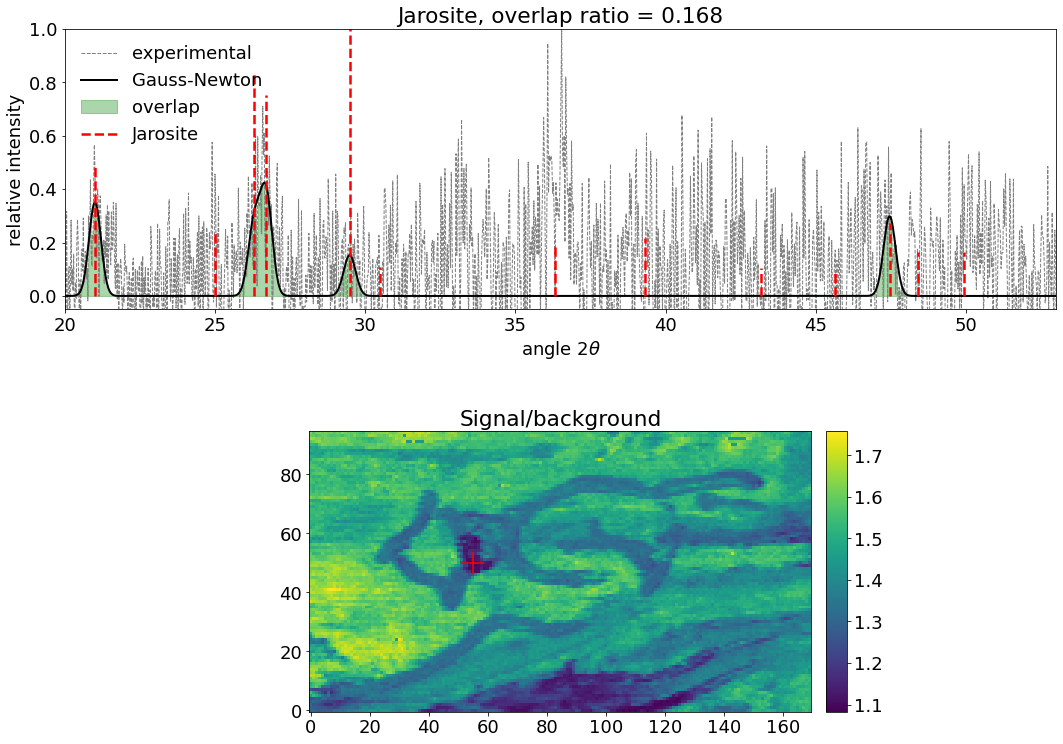

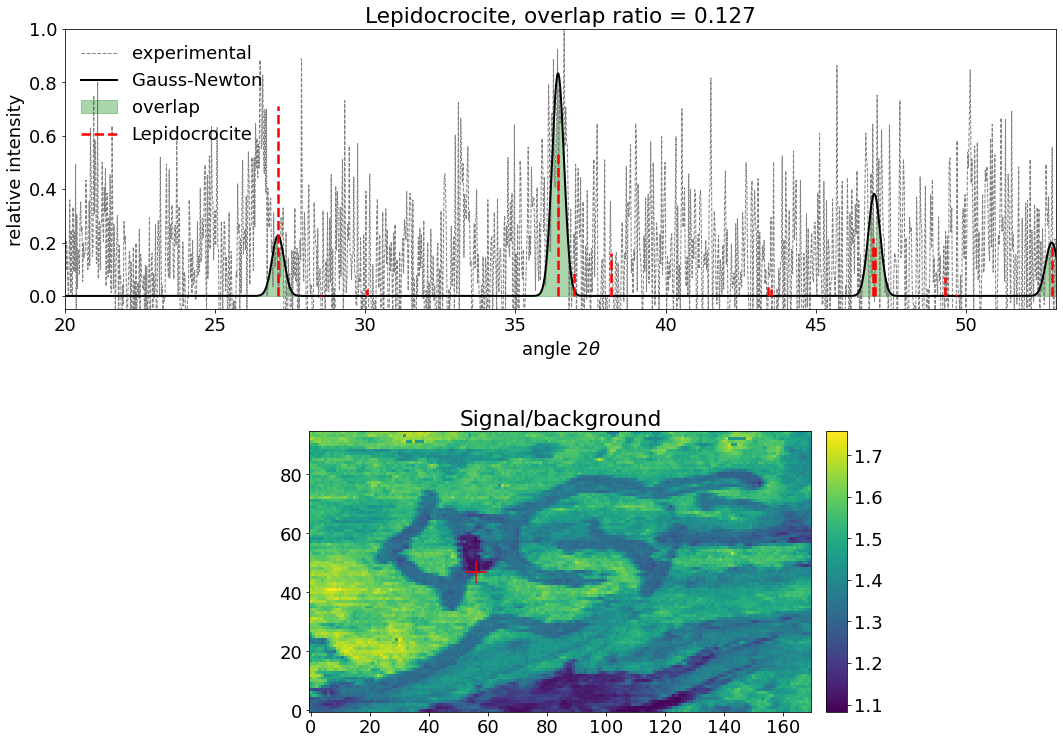

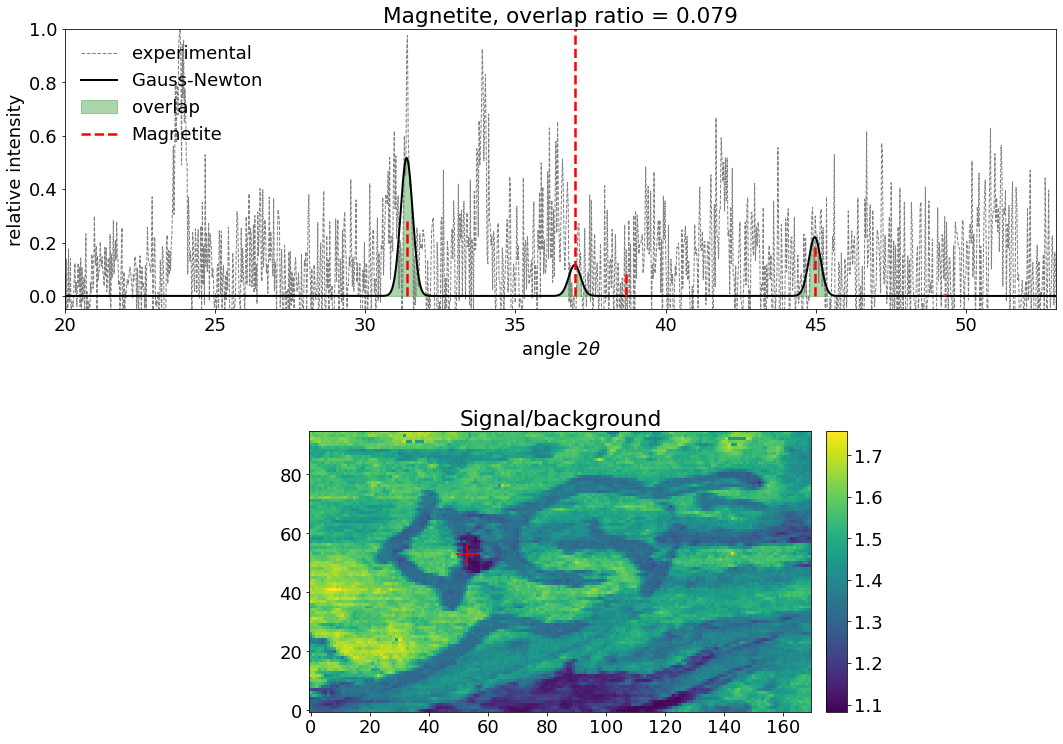

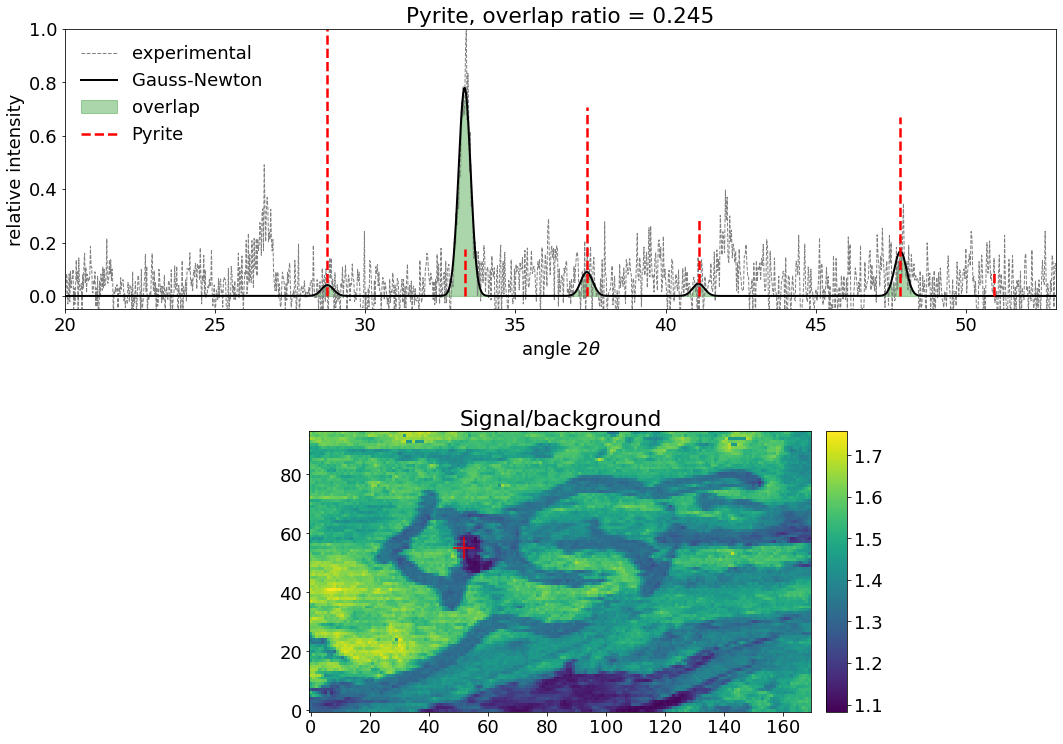

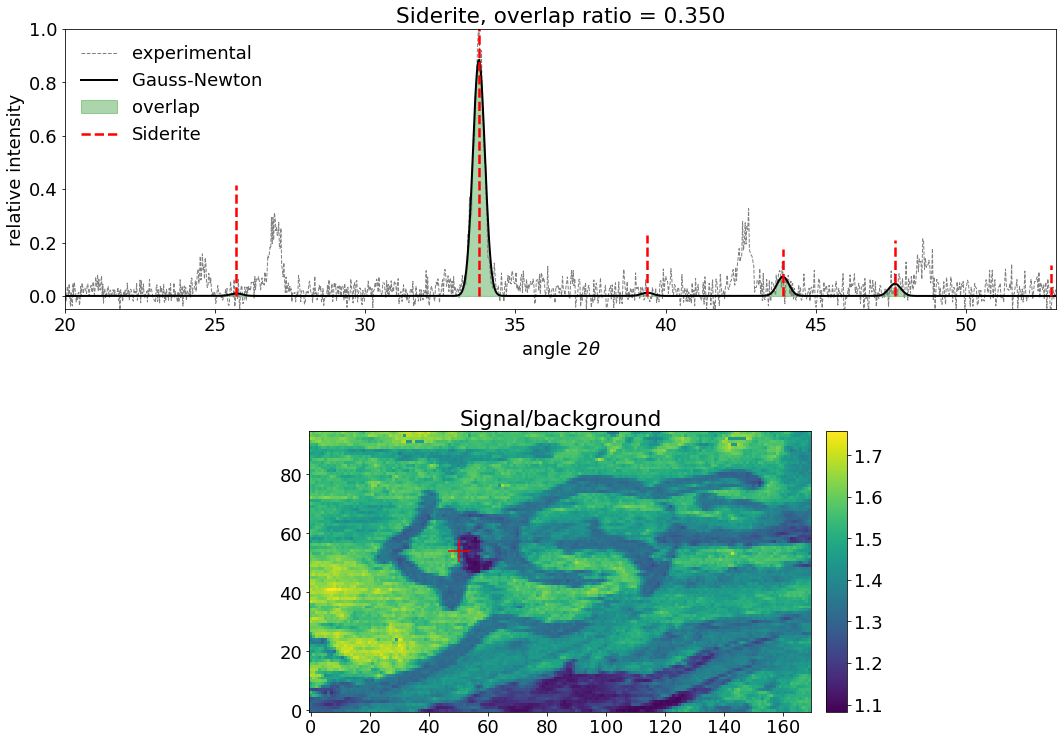

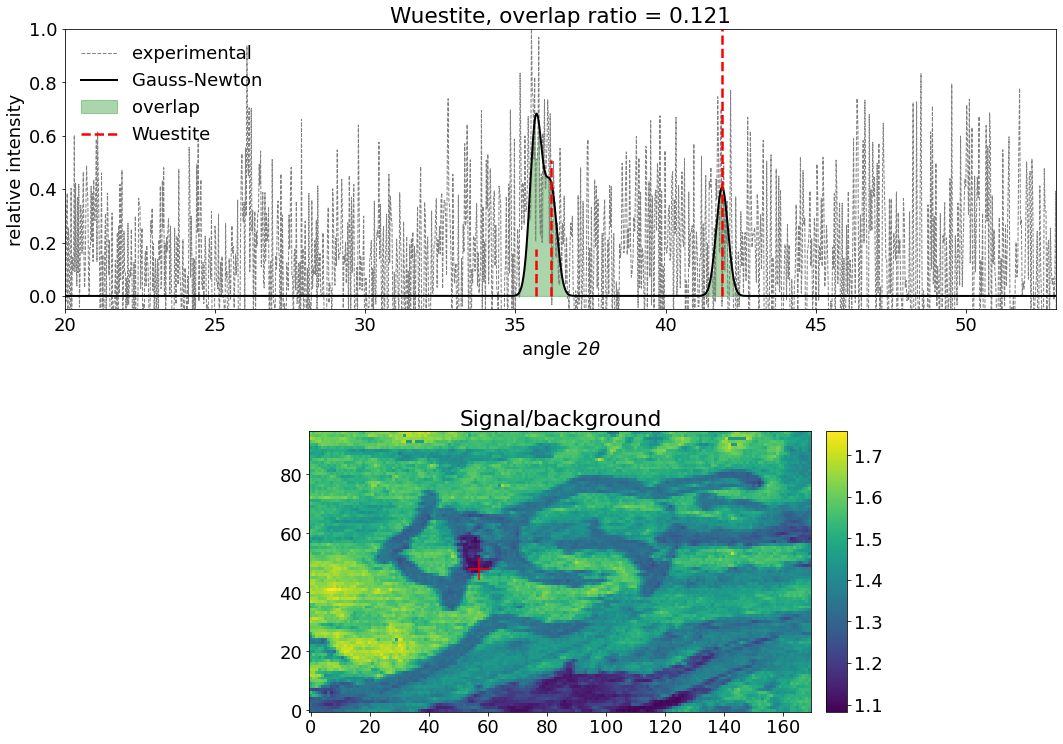

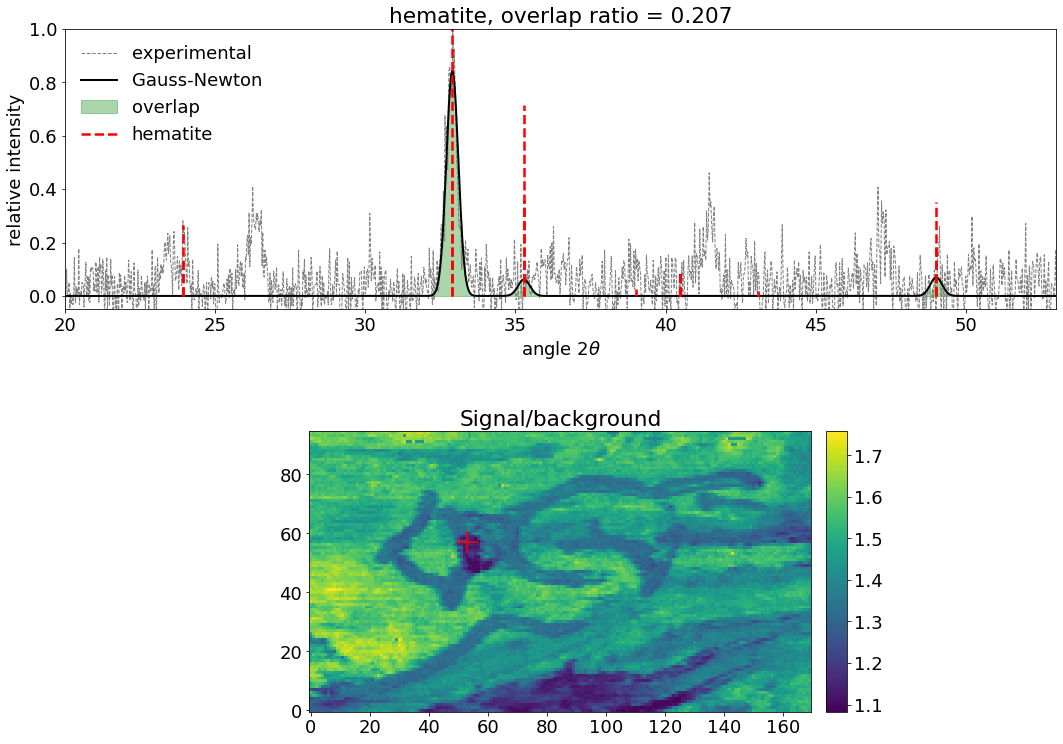

In [42]:
path_phases_check = path_figures + 'phases_check/'

if not isdir(path_phases_check):
    makedirs(path_phases_check)

for i in range(phases_from_elements.shape[0]):
    x, y = phases_from_elements.iloc[i]['(x, y) best max']
    phase_name = phases_from_elements.iloc[i]['Name in database']
    phase_sample = phases_from_elements.iloc[i]['Sample best max']
    phase_check = database[phase_name][phase_sample]
    gn = GaussNewton(phase_check, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

    ### Leaves initial calibration and only optimizes the heights of the peaks ###
    gn.fit_cycle(gamma = True, steps = 10)

    ### Optimizes calibration and heights of the peaks ###
    #gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)
    
    fig, axs = subplots(2, 1, figsize = (15, 8 * y_x_ratio + 6))
    fig.tight_layout(h_pad = 5)
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    gn.phase.plot(lw = 2.5, alpha = 1)
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'{gn.label}, overlap ratio = {gn.overlap3_area_ratio():.3f}')
    legend(frameon = False, loc = 2)
    
    ax = axs[1]
    im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
    ax.scatter(x, y, s = 500, c = 'red', marker = '+')
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    ax.set_title('Signal/background')
    
    savefig(f'{path_phases_check}{phase_name} check_fit.png', bbox_inches = 'tight', dpi = 300)

### Remove these last figures (WARNING)

In [40]:
if isdir(path_phases_check):
    rmtree(path_phases_check)

### Add these phases to a file

This cell writes the list of names of selected phases into the file `phases_selection.dat`. If the file does not exist, the cell creates it.
- `threshold_avg`: The routine selects phase samples with average overlap above this threshold.
- `threshold_max`: The routine selects phase samples with maximum overlap above this threshold.

In [19]:
threshold_avg = 0.1
threshold_max = 0.2

file = open('phases_selection.dat', 'a')
for i, phase_name in enumerate(list_name):
    if list_index_best_average[i] == list_index_best_max[i]:
        if ((list_value_best_average[i] >= threshold_avg) or (list_value_best_max[i] >= threshold_max)):
            file.write(f'{phase_name}, {list_index_best_average[i]}\n')
    else:
        if list_value_best_average[i] >= threshold_avg:
            file.write(f'{phase_name}, {list_index_best_average[i]}\n')
        if list_value_best_max[i] >= threshold_max:
            file.write(f'{phase_name}, {list_index_best_max[i]}\n')
file.close()

### Delete the list of phases (WARNING)

Delete the file `phases_selection.dat`, with the list of names of selected phases.

In [18]:
remove('phases_selection.dat')

# Check phases in a given point
- `phases_calibration`: the cell will calibrate the experimental XRD pattern on the mix of these phases
- `phase_compare`: the diffraction lines of this phase will be shown for comparison

For simplification, you can define phases. Otherwise, phases can be selected iteratively from database using 'Tab'.

In [20]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

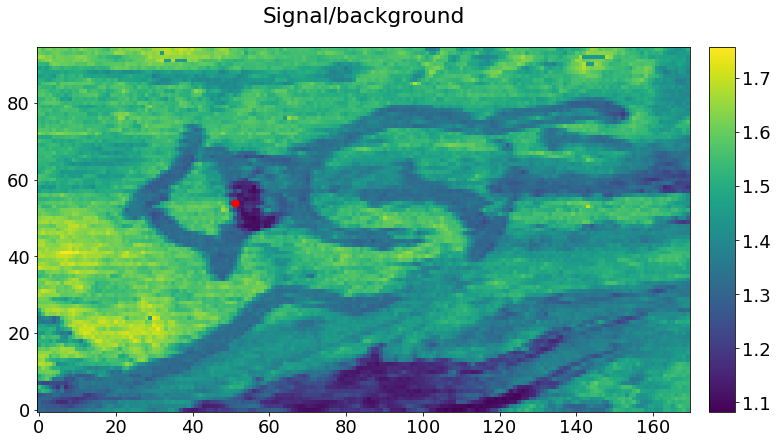

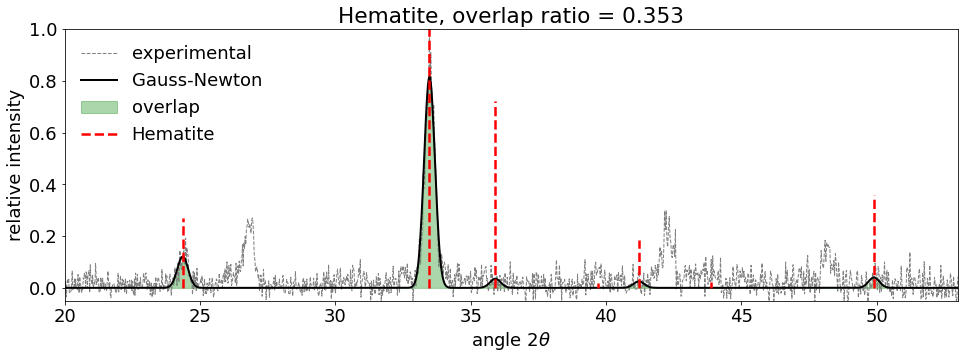

In [21]:
%matplotlib inline
rcParams['font.size'] = 18

x, y = 51, 54

#phases_calibration = PhaseList([database['Hematite'][7]])
phases_calibration = database['Hematite'][7]
#phase_compare = lazurite
#phase_compare = PhaseList([lazurite])
phase_compare = None

fig, ax = subplots(figsize = (12, 12 * y_x_ratio))
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
#im = ax.imshow(presence_phases_sel[1], interpolation = 'none')
ax.scatter(x, y, s = 50, c = 'red', marker = 'o')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/background', y = 1.05)

gn = GaussNewton(phases_calibration, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 5)

### Optimizes calibration and heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
#gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
if phase_compare is not None:
    phase_compare.plot()
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap ratio = {gn.overlap3_area_ratio():.3f}')
legend(frameon = False, loc = 2)
show()